In [1]:
import pandas as pd
import numpy as np
import os

# Load the dataset we created in the previous notebook
data_path = '../data/eth_usdt_h4_features.csv'
df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

print("Data loaded successfully.")
display(df.head())

Data loaded successfully.


,open,high,low,close,volume,ichimoku_senkou_span_a,ichimoku_senkou_span_b,ichimoku_tenkan_sen,ichimoku_kijun_sen,ichimoku_chikou_span,...,BBB_20_2.0,BBP_20_2.0,ATRr_14,ADX_14,DMP_14,DMN_14,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-26 12:00:00,181.35,183.25,178.22,180.85,1126.59285,174.0175,178.475,178.640,175.21,182.98,...,23.468057,0.808489,5.361738,39.691356,41.211618,18.255009,21.781667,0,1,0
2019-10-26 16:00:00,181.01,181.37,174.00,176.45,972.85833,174.0175,178.475,179.285,175.21,182.76,...,23.695357,0.682133,5.505185,38.698888,37.270791,21.984749,20.873333,0,1,0
2019-10-26 20:00:00,176.35,179.85,176.35,179.47,332.56844,173.9075,178.475,181.155,175.21,182.02,...,23.387947,0.732997,5.361957,37.777311,35.533049,20.959715,20.858333,0,1,0
2019-10-27 00:00:00,179.57,181.58,176.89,177.50,607.72330,174.0925,178.475,185.490,175.21,180.28,...,22.966756,0.664517,5.313961,37.144614,35.618404,19.638383,19.245000,0,1,0
2019-10-27 04:00:00,177.46,179.62,176.24,178.61,474.52700,173.6275,178.475,185.490,175.21,181.60,...,22.646074,0.673408,5.175820,36.402931,33.956966,19.619369,17.770000,0,1,0


In [2]:
def define_target(df, profit_pct=0.03, loss_pct=0.015, lookahead_candles=30):
    """
    Creates the target variable for the ML model.
    - 1: BUY (price went up by profit_pct before going down by loss_pct)
    - -1: SELL (price went down by profit_pct before going up by loss_pct)
    - 0: HOLD (neither happened within the lookahead window)
    """
    df['target'] = 0
    
    for i in range(len(df) - lookahead_candles):
        entry_price = df['close'].iloc[i]
        
        # Define the price window to look into the future
        future_window = df['close'].iloc[i+1 : i+1+lookahead_candles]
        
        take_profit_buy = entry_price * (1 + profit_pct)
        stop_loss_buy = entry_price * (1 - loss_pct)
        
        take_profit_sell = entry_price * (1 - profit_pct)
        stop_loss_sell = entry_price * (1 + loss_pct)
        
        # Check for BUY signal outcome
        # Did the price hit our take profit before our stop loss?
        buy_profit_hit_time = future_window[future_window >= take_profit_buy].first_valid_index()
        buy_loss_hit_time = future_window[future_window <= stop_loss_buy].first_valid_index()
        
        if buy_profit_hit_time is not None and (buy_loss_hit_time is None or buy_profit_hit_time < buy_loss_hit_time):
            df['target'].iloc[i] = 1 # BUY
            continue

        # Check for SELL signal outcome
        # Did the price hit our take profit before our stop loss?
        sell_profit_hit_time = future_window[future_window <= take_profit_sell].first_valid_index()
        sell_loss_hit_time = future_window[future_window >= stop_loss_sell].first_valid_index()
            
        if sell_profit_hit_time is not None and (sell_loss_hit_time is None or sell_profit_hit_time < sell_loss_hit_time):
            df['target'].iloc[i] = -1 # SELL
            continue
            
    return df

print("Target definition function created.")

Target definition function created.


Target labeling complete.

Target Distribution:
target
 1    5052
-1    4405
 0    3323
Name: count, dtype: int64


/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_26977/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'].iloc[i] = 1 # BUY
/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_26977/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'].iloc[i] = 1 # BUY
/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_26977/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

<Axes: title={'center': 'Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)'}, xlabel='target'>

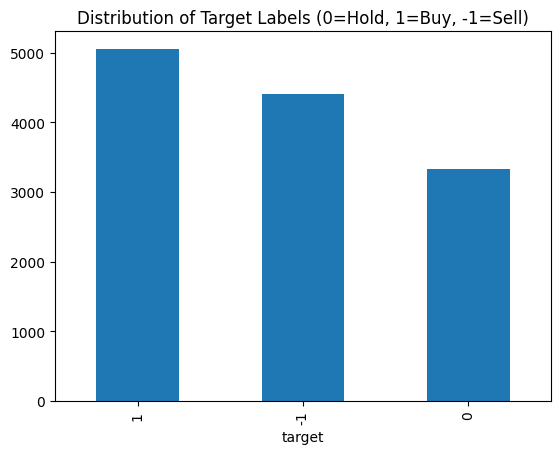

In [3]:
# Apply the function to our DataFrame
# This can take a minute or two to run as it's iterating through the data
labeled_df = define_target(df, profit_pct=0.03, loss_pct=0.015, lookahead_candles=30)

print("Target labeling complete.")

# Analyze the distribution of our targets
target_distribution = labeled_df['target'].value_counts()
print("\nTarget Distribution:")
print(target_distribution)

# Plot the distribution
target_distribution.plot(kind='bar', title='Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)')

In [4]:
# Save the final labeled DataFrame for the model training stage
output_path = '../data/eth_usdt_h4_labeled.csv'
labeled_df.to_csv(output_path)

print(f"Labeled data saved successfully to: {output_path}")

Labeled data saved successfully to: ../data/eth_usdt_h4_labeled.csv
